# LightAutoML installation

In [33]:
!pip install --no-index -U --find-links=/kaggle/input/lightautoml-038-dependecies lightautoml==0.3.8
!pip install --no-index -U --find-links=/kaggle/input/lightautoml-038-dependecies pandas==2.0.3

Looking in links: /kaggle/input/lightautoml-038-dependecies
Processing /kaggle/input/lightautoml-038-dependecies/lightautoml-0.3.8-py3-none-any.whl
Processing /kaggle/input/lightautoml-038-dependecies/AutoWoE-1.3.2-py3-none-any.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/cmaes-0.10.0-py3-none-any.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/joblib-1.2.0-py3-none-any.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/json2html-1.3.0.tar.gz (from lightautoml==0.3.8)
  Preparing metadata (setup.py) ... done
Processing /kaggle/input/lightautoml-038-dependecies/lightgbm-3.2.1-py3-none-manylinux1_x86_64.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/pandas-1.5.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (from lightautoml==0.3.8)
Processing /kaggle/input/lightautoml-038-dependecies/poetry_core-1.8.1-py3-none-any.whl (from lightautoml

In [3]:
%matplotlib inline
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import torch

## Load Data

In [4]:
INPUT_DIR = '../input/linking-writing-processes-to-writing-quality'
train_logs = pd.read_csv(f'{INPUT_DIR}/train_logs.csv')
train_scores = pd.read_csv(f'{INPUT_DIR}/train_scores.csv')
test_logs = pd.read_csv(f'{INPUT_DIR}/test_logs.csv')
ss_df = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

In [12]:
train_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1
...,...,...,...,...,...,...,...,...,...,...,...
8405893,fff05981,3615,2063944,2064440,496,Nonproduction,Leftclick,Leftclick,NoChange,1031,240
8405894,fff05981,3616,2064497,2064497,0,Nonproduction,Shift,Shift,NoChange,1031,240
8405895,fff05981,3617,2064657,2064765,108,Replace,q,q,q => q,1031,240
8405896,fff05981,3618,2069186,2069259,73,Nonproduction,Leftclick,Leftclick,NoChange,1028,240


In [11]:
train_scores

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0
...,...,...
2466,ffb8c745,3.5
2467,ffbef7e5,4.0
2468,ffccd6fd,1.5
2469,ffec5b38,5.0


In [9]:
test_logs

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,0000aaaa,1,338433,338518,85,Input,Space,Space,,0,0
1,0000aaaa,2,760073,760160,87,Input,Space,Space,,1,0
2,2222bbbb,1,711956,712023,67,Input,q,q,q,0,1
3,2222bbbb,2,290502,290548,46,Input,q,q,q,1,1
4,4444cccc,1,635547,635641,94,Input,Space,Space,,0,0
5,4444cccc,2,184996,185052,56,Input,q,q,q,1,1


In [5]:
train_essays = pd.read_csv('../input/writing-quality-challenge-constructed-essays/train_essays_02.csv')
train_essays.index = train_essays["Unnamed: 0"]
train_essays.index.name = None
train_essays.drop(columns=["Unnamed: 0"], inplace=True)
train_essays.head()

,essay
001519c8,qqqqqqqqq qq qqqqq qq qqqq qqqq. qqqqqq qqq q...
0022f953,"qqqq qq qqqqqqqqqqq ? qq qq qqq qqq qqq, qqqqq..."
0042269b,qqqqqqqqqqq qq qqqqq qqqqqqqqq qq qqqqqqqqqqq ...
0059420b,qq qqqqqqq qqqqqq qqqqqqqqqqqqq qqqq q qqqq qq...
0075873a,"qqqqqqqqqqq qq qqq qqqqq qq qqqqqqqqqq, qqq qq..."


## Feature Engineering

In [13]:
# Function to construct essays copied from here (small adjustments): https://www.kaggle.com/code/kawaiicoderuwu/essay-contructor

def getEssays(df):
    textInputDf = df[['id', 'activity', 'cursor_position', 'text_change']]
    textInputDf = textInputDf[textInputDf.activity != 'Nonproduction']
    valCountsArr = textInputDf['id'].value_counts(sort=False).values
    lastIndex = 0
    essaySeries = pd.Series()
    for index, valCount in enumerate(valCountsArr):
        currTextInput = textInputDf[['activity', 'cursor_position', 'text_change']].iloc[lastIndex : lastIndex + valCount]
        lastIndex += valCount
        essayText = ""
        for Input in currTextInput.values:
            if Input[0] == 'Replace':
                replaceTxt = Input[2].split(' => ')
                essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] +\
                essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
                continue
            if Input[0] == 'Paste':
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
                continue
            if Input[0] == 'Remove/Cut':
                essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
                continue
            if "M" in Input[0]:
                croppedTxt = Input[0][10:]
                splitTxt = croppedTxt.split(' To ')
                valueArr = [item.split(', ') for item in splitTxt]
                moveData = (int(valueArr[0][0][1:]), 
                            int(valueArr[0][1][:-1]), 
                            int(valueArr[1][0][1:]), 
                            int(valueArr[1][1][:-1]))
                if moveData[0] != moveData[2]:
                    if moveData[0] < moveData[2]:
                        essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] +\
                        essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                    else:
                        essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] +\
                        essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
                continue
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
        essaySeries[index] = essayText
    essaySeries.index =  textInputDf['id'].unique()
    return pd.DataFrame(essaySeries, columns=['essay'])

In [14]:
# Helper functions

def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

In [15]:
AGGREGATIONS = ['count', 'mean', 'std', 'min', 'max', 'first', 'last', 'sem', q1, 'median', q3, 'skew', pd.DataFrame.kurt, 'sum']

def split_essays_into_sentences(df):
    essay_df = df
    essay_df['id'] = essay_df.index
    essay_df['sent'] = essay_df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',x))
    essay_df = essay_df.explode('sent')
    essay_df['sent'] = essay_df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    essay_df['sent_len'] = essay_df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df['sent_word_count'] = essay_df['sent'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.sent_len!=0].reset_index(drop=True)
    return essay_df

def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    )
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

def split_essays_into_paragraphs(df):
    essay_df = df
    essay_df['id'] = essay_df.index
    essay_df['paragraph'] = essay_df['essay'].apply(lambda x: x.split('\n'))
    essay_df = essay_df.explode('paragraph')
    # Number of characters in paragraphs
    essay_df['paragraph_len'] = essay_df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    essay_df['paragraph_word_count'] = essay_df['paragraph'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.paragraph_len!=0].reset_index(drop=True)
    return essay_df

def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    ) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

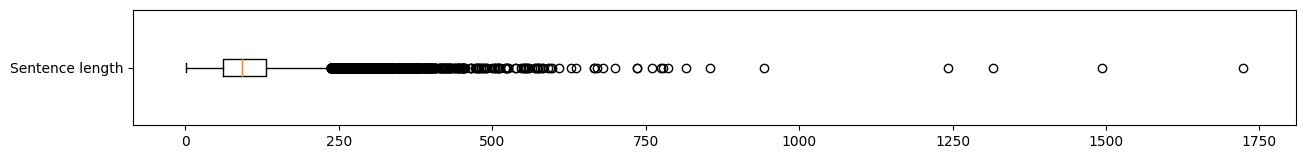

In [18]:
# Sentence features for train dataset
train_sent_df = split_essays_into_sentences(train_essays)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)
plt.figure(figsize=(15, 1.5))
plt.boxplot(x=train_sent_df.sent_len, vert=False, labels=['Sentence length'])
plt.show()

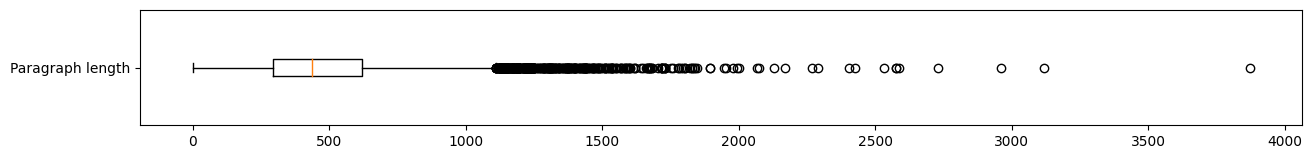

In [19]:
# Paragraph features for train dataset
train_paragraph_df = split_essays_into_paragraphs(train_essays)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)
plt.figure(figsize=(15, 1.5))
plt.boxplot(x=train_paragraph_df.paragraph_len, vert=False, labels=['Paragraph length'])
plt.show()

In [20]:
# Features for test dataset
test_essays = getEssays(test_logs)
test_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(test_essays))
test_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(test_essays))

In [21]:
# The following code comes almost Abdullah's notebook: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
# Abdullah's code is based on work shared in previous notebooks (e.g., https://www.kaggle.com/code/hengzheng/link-writing-simple-lgbm-baseline)

from collections import defaultdict

class Preprocessor:
    
    def __init__(self, seed):
        self.seed = seed
        
        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
        
        self.idf = defaultdict(float)
    
    def activity_counts(self, df):
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['activity'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def event_counts(self, df, colname):
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret

    def text_change_counts(self, df):
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['text_change'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf
            
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret

    def get_input_words(self, df):
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df
    
    def make_feats(self, df):
        
        feats = pd.DataFrame({'id': df['id'].unique().tolist()})
        
        print("Engineering time data")
        for gap in self.gaps:
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering cursor position data")
        for gap in self.gaps:
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        print("Engineering word count data")
        for gap in self.gaps:
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)
        
        print("Engineering statistical summaries for features")
        feats_stat = [
            ('event_id', ['max']),
            ('up_time', ['max']),
            ('action_time', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('cursor_position', ['nunique', 'max', 'quantile', 'sem', 'mean']),
            ('word_count', ['nunique', 'max', 'quantile', 'sem', 'mean'])]
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt])
            ])
        
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')

        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']

        return feats

In [22]:
preprocessor = Preprocessor(seed=42)
train_feats = preprocessor.make_feats(train_logs)
test_feats = preprocessor.make_feats(test_logs)
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
train_feats = train_feats.drop(columns=nan_cols)
test_feats = test_feats.drop(columns=nan_cols)

Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [04:59<00:00,  9.07s/it, column=word_count_change100, method=kurt]         


Engineering activity counts data


100%|██████████| 2471/2471 [00:00<00:00, 4557.22it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 2471/2471 [00:00<00:00, 4696.82it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 2471/2471 [00:00<00:00, 4676.53it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 2471/2471 [00:00<00:00, 4874.26it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 2471/2471 [00:00<00:00, 4659.44it/s]


Engineering input words data


/tmp/ipykernel_47/3946551957.py:221: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
/tmp/ipykernel_47/3946551957.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
/tmp/ipykernel_47/3946551957.py:223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

Engineering ratios data
Engineering time data
Engineering cursor position data
Engineering word count data
Engineering statistical summaries for features


100%|██████████| 33/33 [00:02<00:00, 15.03it/s, column=word_count_change100, method=kurt]         


Engineering activity counts data


100%|██████████| 3/3 [00:00<00:00, 17213.29it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering event counts data


100%|██████████| 3/3 [00:00<00:00, 20327.81it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
100%|██████████| 3/3 [00:00<00:00, 12169.16it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering text change counts data


100%|██████████| 3/3 [00:00<00:00, 13934.56it/s]
/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Engineering punctuation counts data


100%|██████████| 3/3 [00:00<00:00, 7129.13it/s]
/tmp/ipykernel_47/3946551957.py:221: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
/tmp/ipykernel_47/3946551957.py:222: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
/tmp/ipykernel_47/3946551957.py:223: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor 

Engineering input words data
Engineering ratios data


In [23]:
# Code for additional aggregations comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs

train_agg_fe_df = train_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

test_agg_fe_df = test_logs.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(
    ['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
test_agg_fe_df.columns = ['_'.join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

train_feats = train_feats.merge(train_agg_fe_df, on='id', how='left')
test_feats = test_feats.merge(test_agg_fe_df, on='id', how='left')

In [24]:
# Code for creating these features comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs
# Idea is based on features introduced in Section 3 of this research paper: https://files.eric.ed.gov/fulltext/ED592674.pdf

data = []

for logs in [train_logs, test_logs]:
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674, test_eD592674 = data

train_feats = train_feats.merge(train_eD592674, on='id', how='left')
test_feats = test_feats.merge(test_eD592674, on='id', how='left')
train_feats = train_feats.merge(train_scores, on='id', how='left')

In [25]:
# Adding the additional features to the original feature set

train_feats = train_feats.merge(train_sent_agg_df, on='id', how='left')
train_feats = train_feats.merge(train_paragraph_agg_df, on='id', how='left')
test_feats = test_feats.merge(test_sent_agg_df, on='id', how='left')
test_feats = test_feats.merge(test_paragraph_agg_df, on='id', how='left')

In [27]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [28]:
len(test_feats)

3

# LightGBM train and predict

In [29]:
OOF_PREDS = np.zeros((len(train_feats), 2))
TEST_PREDS = np.zeros((len(test_feats), 2))

In [30]:
# Code comes from here: https://www.kaggle.com/code/abdullahmeda/enter-ing-the-timeseries-space-sec-3-new-aggs

models_dict = {}
scores = []

test_predict_list = []
best_params = {'reg_alpha': 0.007678095440286993, 
               'reg_lambda': 0.34230534302168353, 
               'colsample_bytree': 0.627061253588415, 
               'subsample': 0.854942238828458, 
               'learning_rate': 0.04,   #0.038697981947473245, 
               'num_leaves': 22, 
               'max_depth': 37, 
               'min_child_samples': 18,
               'n_jobs':4
              }

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)
    oof_valid_preds = np.zeros(train_feats.shape[0])
    X_test = test_feats[train_cols]
    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
        
        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]
        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            "verbosity": -1,
            **best_params
        }
        model = lgb.LGBMRegressor(**params)
        early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback],
        )
        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict
        OOF_PREDS[valid_idx, 0] += valid_predict / 5
        test_predict = model.predict(X_test)
        TEST_PREDS[:, 0] += test_predict / 5 / 10
        test_predict_list.append(test_predict)
        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        models_dict[f'{fold}_{i}'] = model

    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)

In [31]:
print('OOF metric LGBM = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_PREDS[:, 0], 
                                                                   squared=False)))

OOF metric LGBM = 0.61522


# LightAutoML NN (DenseLight) prediction

In [34]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task
import joblib

# def use_plr(USE_PLR):
#     if USE_PLR:
#         return "plr"
#     else:
#         return "cont"

In [35]:
for i in range(3):
    oof_pred, automl = joblib.load('/kaggle/input/linkinglamamodels/oof_and_lama_denselight_{}.pkl'.format(i))
    OOF_PREDS[:, 1] += oof_pred / 3
    TEST_PREDS[:, 1] += automl.predict(test_feats[train_cols]).data[:, 0] / 3

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator QuantileTransformer from version 1.3.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your o

In [36]:
print('OOF metric LightAutoML_NN = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                               OOF_PREDS[:, 1], 
                                                                               squared=False)))

OOF metric LightAutoML_NN = 0.61386


# Blending

In [37]:
best_sc = 1
for w in np.arange(0, 1.01, 0.001):
    sc = metrics.mean_squared_error(train_feats[target_col], 
                                    w * OOF_PREDS[:, 0] + (1-w) * OOF_PREDS[:, 1], 
                                    squared=False)
    if sc < best_sc:
        best_sc = sc
        best_w = w
        
print('Composition OOF score = {:.5f}'.format(best_sc))
print('Composition best W = {:.3f}'.format(best_w))

Composition OOF score = 0.60851
Composition best W = 0.472


# Submission creation

In [38]:
W = [best_w, 1 - best_w]
print(W)
test_preds = TEST_PREDS[:, 0] * W[0] + TEST_PREDS[:, 1] * W[1]
test_preds

[0.47200000000000003, 0.528]


array([1.66823226, 0.99674628, 0.95888981])

In [39]:
test_feats['score'] = test_preds
sub1 = test_feats[['id', 'score']]
#test_feats[['id', 'score']].to_csv("submission.csv", index=False)

/tmp/ipykernel_47/1024135510.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_feats['score'] = test_preds


In [40]:
sub1

,id,score
0,0000aaaa,1.668232
1,2222bbbb,0.996746
2,4444cccc,0.958890


In [41]:
sub1.to_csv('submission.csv',index=False
           )

# Saving OOFs and test predictions

In [ ]:
joblib.dump((OOF_PREDS, TEST_PREDS), 'OOF_and_TEST_preds.pkl')

# Public LGBM

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import gc
import ctypes
def clean_memory():
    gc.collect()
    ctypes.CDLL("libc.so.6").malloc_trim(0)
    torch.cuda.empty_cache()
clean_memory()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
%matplotlib inline
import gc
import os
import itertools
import pickle

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
from transformers import BertTokenizer
import warnings

import os
import gc
import re
import random
from collections import Counter, defaultdict
import pprint
import time
import copy


import seaborn as sns
from tqdm.autonotebook import tqdm

# from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder, PowerTransformer, RobustScaler, FunctionTransformer
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna

In [ ]:
traindf = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv')
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv')
testdf = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv')

In [ ]:
def getEssays(df):
    # Copy required columns
    textInputDf = df[['id', 'activity', 'cursor_position', 'text_change']].copy()
    
    # Get rid of text inputs that make no change
    # Note: Shift was unpreditcable so ignored
    textInputDf = textInputDf[textInputDf.activity != 'Nonproduction']

    # Get how much each Id there is
    valCountsArr = textInputDf['id'].value_counts(sort=False).values

    # Holds the final index of the previous Id
    lastIndex = 0

    # Holds all the essays
    essaySeries = pd.Series()

    # Fills essay series with essays
    for index, valCount in enumerate(valCountsArr):

        # Indexes down_time at current Id
        currTextInput = textInputDf[['activity', 'cursor_position', 'text_change']].iloc[lastIndex : lastIndex + valCount]

        # Update the last index
        lastIndex += valCount

        # Where the essay content will be stored
        essayText = ""

        
        # Produces the essay
        for Input in currTextInput.values:
            
            # Input[0] = activity
            # Input[2] = cursor_position
            # Input[3] = text_change
            
            # If activity = Replace
            if Input[0] == 'Replace':
                # splits text_change at ' => '
                replaceTxt = Input[2].split(' => ')
                
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(replaceTxt[1])] + replaceTxt[1] + essayText[Input[1] - len(replaceTxt[1]) + len(replaceTxt[0]):]
                continue

                
            # If activity = Paste    
            if Input[0] == 'Paste':
                # DONT TOUCH
                essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]
                continue

                
            # If activity = Remove/Cut
            if Input[0] == 'Remove/Cut':
                # DONT TOUCH
                essayText = essayText[:Input[1]] + essayText[Input[1] + len(Input[2]):]
                continue

                
            # If activity = Move...
            if "M" in Input[0]:
                # Gets rid of the "Move from to" text
                croppedTxt = Input[0][10:]
                
                # Splits cropped text by ' To '
                splitTxt = croppedTxt.split(' To ')
                
                # Splits split text again by ', ' for each item
                valueArr = [item.split(', ') for item in splitTxt]
                
                # Move from [2, 4] To [5, 7] = (2, 4, 5, 7)
                moveData = (int(valueArr[0][0][1:]), int(valueArr[0][1][:-1]), int(valueArr[1][0][1:]), int(valueArr[1][1][:-1]))

                # Skip if someone manages to activiate this by moving to same place
                if moveData[0] != moveData[2]:
                    # Check if they move text forward in essay (they are different)
                    if moveData[0] < moveData[2]:
                        # DONT TOUCH
                        essayText = essayText[:moveData[0]] + essayText[moveData[1]:moveData[3]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[3]:]
                    else:
                        # DONT TOUCH
                        essayText = essayText[:moveData[2]] + essayText[moveData[0]:moveData[1]] + essayText[moveData[2]:moveData[0]] + essayText[moveData[1]:]
                continue
                
                
            # If just input
            # DONT TOUCH
            essayText = essayText[:Input[1] - len(Input[2])] + Input[2] + essayText[Input[1] - len(Input[2]):]

            
        # Sets essay at index  
        essaySeries[index] = essayText
     
    
    # Sets essay series index to the ids
    essaySeries.index =  textInputDf['id'].unique()
    
    
    # Returns the essay series
    return essaySeries

In [ ]:
%%time
train_essays = getEssays(traindf)

In [ ]:
test_essays = getEssays(testdf)

In [ ]:
train_essaysdf = pd.DataFrame({'id': train_essays.index, 'essay': train_essays.values})
test_essaysdf = pd.DataFrame({'id': test_essays.index, 'essay': test_essays.values})

In [ ]:
merged_data = train_essaysdf.merge(train_scores, on='id')

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_tokenizer_train = count_vectorizer.fit_transform(merged_data['essay'])
X_tokenizer_test = count_vectorizer.transform(test_essaysdf['essay'])
count_vectorizer.get_feature_names_out() #ADDED
y = merged_data['score']

In [ ]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [ ]:
X_tokenizer_train = X_tokenizer_train.todense()
X_tokenizer_test = X_tokenizer_test.todense()

In [ ]:
for i in range(X_tokenizer_train.shape[1]) : 
    L = list(X_tokenizer_train[:,i])
    li = [int(x) for x in L ]
    df_train[f'feature {i}'] = li

In [ ]:
for i in range(X_tokenizer_test.shape[1]) : 
    L = list(X_tokenizer_test[:,i])
    li = [int(x) for x in L ]
    df_test[f'feature {i}'] = li

In [ ]:
df_train_index = train_essaysdf['id']
df_test_index = test_essaysdf['id']

In [ ]:
df_train.loc[:, 'id'] = df_train_index
df_test.loc[:, 'id'] = df_test_index

In [ ]:
train_agg_fe_df = traindf.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
train_agg_fe_df.columns = ['_'.join(x) for x in train_agg_fe_df.columns]
train_agg_fe_df = train_agg_fe_df.add_prefix("tmp_")
train_agg_fe_df.reset_index(inplace=True)

In [ ]:
test_agg_fe_df = testdf.groupby("id")[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']].agg(['mean', 'std', 'min', 'max', 'last', 'first', 'sem', 'median', 'sum'])
test_agg_fe_df.columns = ['_'.join(x) for x in test_agg_fe_df.columns]
test_agg_fe_df = test_agg_fe_df.add_prefix("tmp_")
test_agg_fe_df.reset_index(inplace=True)

In [ ]:
from collections import defaultdict

class Preprocessor:
    
    def __init__(self, seed):
        self.seed = seed
        
        self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
        self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',', 
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
        self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
        self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
        self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
        
        self.idf = defaultdict(float)
#         self.gaps = [1, 2]
    
    def activity_counts(self, df):
        tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['activity'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.activities:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf

            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret


    def event_counts(self, df, colname):
        tmp_df = df.groupby('id').agg({colname: list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df[colname].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.events:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf

        return ret


    def text_change_counts(self, df):
        tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['text_change'].values):
            items = list(Counter(li).items())
            di = dict()
            for k in self.text_changes:
                di[k] = 0
            for item in items:
                k, v = item[0], item[1]
                if k in di:
                    di[k] = v
            ret.append(di)
        ret = pd.DataFrame(ret)
        cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
        ret.columns = cols

        cnts = ret.sum(1)

        for col in cols:
            if col in self.idf.keys():
                idf = self.idf[col]
            else:
                idf = df.shape[0] / (ret[col].sum() + 1)
                idf = np.log(idf)
                self.idf[col] = idf
            
            ret[col] = 1 + np.log(ret[col] / cnts)
            ret[col] *= idf
            
        return ret

    def match_punctuations(self, df):
        tmp_df = df.groupby('id').agg({'down_event': list}).reset_index()
        ret = list()
        for li in tqdm(tmp_df['down_event'].values):
            cnt = 0
            items = list(Counter(li).items())
            for item in items:
                k, v = item[0], item[1]
                if k in self.punctuations:
                    cnt += v
            ret.append(cnt)
        ret = pd.DataFrame({'punct_cnt': ret})
        return ret


    def get_input_words(self, df):
        tmp_df = df[(~df['text_change'].str.contains('=>'))&(df['text_change'] != 'NoChange')].reset_index(drop=True)
        tmp_df = tmp_df.groupby('id').agg({'text_change': list}).reset_index()
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: ''.join(x))
        tmp_df['text_change'] = tmp_df['text_change'].apply(lambda x: re.findall(r'q+', x))
        tmp_df['input_word_count'] = tmp_df['text_change'].apply(len)
        tmp_df['input_word_length_mean'] = tmp_df['text_change'].apply(lambda x: np.mean([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_max'] = tmp_df['text_change'].apply(lambda x: np.max([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df['input_word_length_std'] = tmp_df['text_change'].apply(lambda x: np.std([len(i) for i in x] if len(x) > 0 else 0))
        tmp_df.drop(['text_change'], axis=1, inplace=True)
        return tmp_df
    
    def make_feats(self, df):
        
        print("Starting to engineer features")
        
        # initialize features dataframe
        feats = pd.DataFrame({'id': df['id'].unique().tolist()})
        
        # get shifted features
        # time shift
        print("Engineering time data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
            df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
        df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

        # cursor position shift
        print("Engineering cursor position data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
            df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
            df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
        df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

        # word count shift
        print("Engineering word count data")
        for gap in self.gaps:
            print(f"> for gap {gap}")
            df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
            df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
            df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
        df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)
        
        # get aggregate statistical features
        print("Engineering statistical summaries for features")
        # [(feature name, [ stat summaries to add ])]
        feats_stat = [
            ('event_id', ['max']),
            ('up_time', ['max']),
            ('action_time', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
            ('activity', ['nunique']),
            ('down_event', ['nunique']),
            ('up_event', ['nunique']),
            ('text_change', ['nunique']),
            ('cursor_position', ['nunique', 'max', 'quantile', 'sem', 'mean']),
            ('word_count', ['nunique', 'max', 'quantile', 'sem', 'mean'])]
        for gap in self.gaps:
            feats_stat.extend([
                (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt]),
                (f'word_count_change{gap}', ['max', 'mean', 'std', 'quantile', 'sem', 'sum', 'skew', pd.DataFrame.kurt])
            ])
        
        pbar = tqdm(feats_stat)
        for item in pbar:
            colname, methods = item[0], item[1]
            for method in methods:
                pbar.set_postfix()
                if isinstance(method, str):
                    method_name = method
                else:
                    method_name = method.__name__
                    
                pbar.set_postfix(column=colname, method=method_name)
                tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
                feats = feats.merge(tmp_df, on='id', how='left')

        # counts
        print("Engineering activity counts data")
        tmp_df = self.activity_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering event counts data")
        tmp_df = self.event_counts(df, 'down_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        tmp_df = self.event_counts(df, 'up_event')
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering text change counts data")
        tmp_df = self.text_change_counts(df)
        feats = pd.concat([feats, tmp_df], axis=1)
        
        print("Engineering punctuation counts data")
        tmp_df = self.match_punctuations(df)
        feats = pd.concat([feats, tmp_df], axis=1)

        # input words
        print("Engineering input words data")
        tmp_df = self.get_input_words(df)
        feats = pd.merge(feats, tmp_df, on='id', how='left')

        # compare feats
        print("Engineering ratios data")
        feats['word_time_ratio'] = feats['word_count_max'] / feats['up_time_max']
        feats['word_event_ratio'] = feats['word_count_max'] / feats['event_id_max']
        feats['event_time_ratio'] = feats['event_id_max']  / feats['up_time_max']
        feats['idle_time_ratio'] = feats['action_time_gap1_sum'] / feats['up_time_max']
        
        print("Done!")
        return feats

In [ ]:
preprocessor = Preprocessor(seed=42)

print("Engineering features for training data")

other_train_feats = preprocessor.make_feats(traindf)

print()
print("-"*25)
print("Engineering features for test data")
print("-"*25)
other_test_feats = preprocessor.make_feats(testdf)

In [ ]:
df_train_all = pd.DataFrame()
df_test_all = pd.DataFrame()

In [ ]:
df_train_all = df_train.merge(train_agg_fe_df,on='id')

In [ ]:
df_test_all = df_test.merge(test_agg_fe_df,on='id')

In [ ]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

In [ ]:
AGGREGATIONS = ['count', 'mean', 'std', 'min', 'max', 'first', 'last', 'sem', q1, 'median', q3, 'skew', pd.DataFrame.kurt, 'sum']

def split_essays_into_sentences(df):
    essay_df = df
    essay_df['id'] = essay_df.index
    essay_df['sent'] = essay_df['essay'].apply(lambda x: re.split('\\.|\\?|\\!',str(x)))
    essay_df = essay_df.explode('sent')
    essay_df['sent'] = essay_df['sent'].apply(lambda x: x.replace('\n','').strip())
    # Number of characters in sentences
    essay_df['sent_len'] = essay_df['sent'].apply(lambda x: len(x))
    # Number of words in sentences
    essay_df['sent_word_count'] = essay_df['sent'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.columns.tolist()].reset_index(drop=True)
    return essay_df

def compute_sentence_aggregations(df):
    sent_agg_df = pd.concat(
        [df[['id','sent_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','sent_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    )
    sent_agg_df.columns = ['_'.join(x) for x in sent_agg_df.columns]
    sent_agg_df['id'] = sent_agg_df.index
    sent_agg_df = sent_agg_df.reset_index(drop=True)
    sent_agg_df.drop(columns=["sent_word_count_count"], inplace=True)
    sent_agg_df = sent_agg_df.rename(columns={"sent_len_count":"sent_count"})
    return sent_agg_df

def split_essays_into_paragraphs(df):
    essay_df = df
    essay_df['id'] = essay_df.index
    essay_df['paragraph'] = essay_df['essay'].apply(lambda x: str(x).split('\n'))
    essay_df = essay_df.explode('paragraph')
    # Number of characters in paragraphs
    essay_df['paragraph_len'] = essay_df['paragraph'].apply(lambda x: len(x)) 
    # Number of words in paragraphs
    essay_df['paragraph_word_count'] = essay_df['paragraph'].apply(lambda x: len(x.split(' ')))
    essay_df = essay_df[essay_df.paragraph_len!=0].reset_index(drop=True)
    return essay_df

def compute_paragraph_aggregations(df):
    paragraph_agg_df = pd.concat(
        [df[['id','paragraph_len']].groupby(['id']).agg(AGGREGATIONS), df[['id','paragraph_word_count']].groupby(['id']).agg(AGGREGATIONS)], axis=1
    ) 
    paragraph_agg_df.columns = ['_'.join(x) for x in paragraph_agg_df.columns]
    paragraph_agg_df['id'] = paragraph_agg_df.index
    paragraph_agg_df = paragraph_agg_df.reset_index(drop=True)
    paragraph_agg_df.drop(columns=["paragraph_word_count_count"], inplace=True)
    paragraph_agg_df = paragraph_agg_df.rename(columns={"paragraph_len_count":"paragraph_count"})
    return paragraph_agg_df

In [ ]:
train_sent_df = split_essays_into_sentences(train_essaysdf)
train_sent_agg_df = compute_sentence_aggregations(train_sent_df)

In [ ]:
train_paragraph_df = split_essays_into_paragraphs(train_essaysdf)
train_paragraph_agg_df = compute_paragraph_aggregations(train_paragraph_df)

In [ ]:
test_sent_agg_df = compute_sentence_aggregations(split_essays_into_sentences(test_essaysdf))
test_paragraph_agg_df = compute_paragraph_aggregations(split_essays_into_paragraphs(test_essaysdf))

In [ ]:
train_paragraph_agg_df.loc[:, 'id'] = df_train_index
train_sent_agg_df.loc[:, 'id'] = df_train_index

In [ ]:
test_paragraph_agg_df.loc[:, 'id'] = df_test_index
test_sent_agg_df.loc[:, 'id'] = df_test_index

In [ ]:
new_train_feats = pd.DataFrame()
new_test_feats = pd.DataFrame()

In [ ]:
new_train_feats = train_paragraph_agg_df.merge(df_train_all,on='id')
new_train_feats = new_train_feats.merge(train_sent_agg_df,on='id')

In [ ]:
new_test_feats = test_paragraph_agg_df.merge(df_test_all,on='id')
new_test_feats = new_test_feats.merge(test_sent_agg_df,on='id')

In [ ]:
train_feats = pd.DataFrame()
test_feats = pd.DataFrame()

In [ ]:
train_feats = new_train_feats.merge(other_train_feats,on='id')
test_feats = new_test_feats.merge(other_test_feats,on='id')

In [ ]:
data = []

for logs in [traindf, testdf]:
    logs['up_time_lagged'] = logs.groupby('id')['up_time'].shift(1).fillna(logs['down_time'])
    logs['time_diff'] = abs(logs['down_time'] - logs['up_time_lagged']) / 1000

    group = logs.groupby('id')['time_diff']
    largest_lantency = group.max()
    smallest_lantency = group.min()
    median_lantency = group.median()
    initial_pause = logs.groupby('id')['down_time'].first() / 1000
    pauses_half_sec = group.apply(lambda x: ((x > 0.5) & (x < 1)).sum())
    pauses_1_sec = group.apply(lambda x: ((x > 1) & (x < 1.5)).sum())
    pauses_1_half_sec = group.apply(lambda x: ((x > 1.5) & (x < 2)).sum())
    pauses_2_sec = group.apply(lambda x: ((x > 2) & (x < 3)).sum())
    pauses_3_sec = group.apply(lambda x: (x > 3).sum())

    data.append(pd.DataFrame({
        'id': logs['id'].unique(),
        'largest_lantency': largest_lantency,
        'smallest_lantency': smallest_lantency,
        'median_lantency': median_lantency,
        'initial_pause': initial_pause,
        'pauses_half_sec': pauses_half_sec,
        'pauses_1_sec': pauses_1_sec,
        'pauses_1_half_sec': pauses_1_half_sec,
        'pauses_2_sec': pauses_2_sec,
        'pauses_3_sec': pauses_3_sec,
    }).reset_index(drop=True))

train_eD592674, test_eD592674 = data

train_feats = train_feats.merge(train_eD592674, on='id', how='left')
test_feats = test_feats.merge(test_eD592674, on='id', how='left')
train_feats = train_feats.merge(train_scores, on='id', how='left')

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

train_feats['score_class'] = le.fit_transform(train_feats['score'])

In [ ]:
target_col = ['score']

drop_cols = ['id', 'score_class']
train_cols = list()

train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

train_cols.__len__(), target_col.__len__()

In [ ]:
nan_cols = train_feats.columns[train_feats.isna().any()].tolist()
nan_cols

In [ ]:
for col in nan_cols:
    mode_value_train = train_feats[col].mode()[0]  # In case there are multiple modes, choose the first one
    train_feats[col].fillna(mode_value_train, inplace=True)

In [ ]:
for col in test_feats.columns[test_feats.isna().any()].tolist():
    # Find the most frequent value in the training set for the current feature
    most_frequent_value_train = train_feats[col].mode()[0]
    
    # Fill missing values in the test set with the most frequent value from the training set
    test_feats[col].fillna(most_frequent_value_train, inplace=True)

train_feats.shape, test_feats.shape

In [ ]:
train_feats.columns[train_feats.isna().any()].tolist()

In [ ]:
nan_values_test = test_feats.columns[test_feats.isna().any()].tolist()

In [ ]:
clean_memory()

In [ ]:
models_dict = {}
scores = []

test_predict_list = []
best_params = {'boosting_type': 'gbdt', 
               'metric': 'rmse',
               'reg_alpha': 0.003188447814669599, 
               'reg_lambda': 0.0010228604507564066, 
               'colsample_bytree': 0.5420247656839267, 
               'subsample': 0.9778252382803456, 
               'feature_fraction': 0.8,
               'bagging_freq': 1,
               'bagging_fraction': 0.75,
               'learning_rate': 0.01716485155812008, 
               'num_leaves': 19, 
               'min_child_samples': 46,
               'verbosity': -1,
               'random_state': 42,
               'n_estimators': 500,
               'device_type': 'cpu'}

for i in range(5): 
    kf = model_selection.KFold(n_splits=10, random_state=42 + i, shuffle=True)

    oof_valid_preds = np.zeros(train_feats.shape[0], )

    X_test = test_feats[train_cols]


    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):

        print("==-"* 50)
        print("Fold : ", fold)

        X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
        X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

        print("Trian :", X_train.shape, y_train.shape)
        print("Valid :", X_valid.shape, y_valid.shape)

        params = {
            "objective": "regression",
            "metric": "rmse",
            'random_state': 42,
            "n_estimators" : 12001,
            "verbosity": -1,
            "device_type": "cpu",
            **best_params
        }

        model = lgb.LGBMRegressor(**params)

        early_stopping_callback = lgb.early_stopping(200, first_metric_only=True, verbose=False)
        verbose_callback = lgb.callback.record_evaluation({})

        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  
                  callbacks=[early_stopping_callback, verbose_callback],
        )

        valid_predict = model.predict(X_valid)
        oof_valid_preds[valid_idx] = valid_predict

        test_predict = model.predict(X_test)
        test_predict_list.append(test_predict)

        score = metrics.mean_squared_error(y_valid, valid_predict, squared=False)
        print("Fold RMSE Score : ", score)

        models_dict[f'{fold}_{i}'] = model


    oof_score = metrics.mean_squared_error(train_feats[target_col], oof_valid_preds, squared=False)
    scores.append(oof_score)
    print("OOF RMSE Score : ", oof_score)

In [ ]:
feature_importances_values = np.asarray([model.feature_importances_ for model in models_dict.values()]).mean(axis=0)
feature_importance_df = pd.DataFrame({'name': train_cols, 'importance': feature_importances_values})

feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

In [ ]:
np.mean(scores)

In [ ]:
plt.figure(figsize=(15, 6))

ax = sns.barplot(data=feature_importance_df.head(30), x='name', y='importance')
ax.set_title(f"Mean feature importances")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)

plt.show()

In [ ]:
test_feats['score'] = np.mean(test_predict_list, axis=0)

In [ ]:
sub2 = test_feats[['id', 'score']]

# Submission

In [ ]:
clean_memory()

In [ ]:
sub1.rename(columns={'score': 'score_1'}, inplace=True)
sub2.rename(columns={'score': 'score_2'}, inplace=True)
submission = pd.merge(sub1, sub2, on='id')
submission['score'] = ((submission['score_1'] * (1/2)) +  #LGBM + NN (Weighted search for "print(W)")
                       (submission['score_2'] * (1/2)))   #LGBM Public

submission_final = submission[['id', 'score']]

In [ ]:
submission_final.to_csv('submission.csv', index=False)

In [ ]:
submission_final